In [159]:
# Import Dependencies
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [147]:
# Reading and dropping unneeded columns
df = pd.read_csv('data/consumer_data.csv')
df = df.drop(['Channel', 'Region'], axis=1)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


<h1>ANALYSIS</h1>

In [177]:
# Given a dataframe, return the lables and cluster centers
def getKMeansClusters(df, print_clusters=True):
    km = KMeans(n_clusters=5, max_iter=500).fit(df)
    labels = km.labels_
    cluster_centers = km.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    if print_clusters:
        print(cluster_centers)
        print("Number of estimated clusters:", n_clusters_)
    return labels, cluster_centers

In [178]:
# Removing outliers based on standard deviation
low = 0.02
high = 0.98
quant_df = df.quantile([low, high])
filt_df = df.apply(lambda x: x[(x>quant_df.loc[low, x.name]) &
                               (x < quant_df.loc[high, x.name])], axis=0)
filt_df.dropna(inplace=True)

In [217]:
quant_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0.02,134.94,336.12,524.10,72.02,23.90,21.12
0.98,46047.66,27659.88,32437.84,15807.14,17927.88,6276.84


In [181]:
print(filt_df.shape)
_,_ = getMeanShiftClusters(filt_df)
_,_ = getKMeansClusters(filt_df)

(369, 6)
[[  7828.81355932   3289.36440678   4249.65677966   2355.43220339
    1319.82627119   1006.78389831]
 [ 31012.          16687.           5429.          15082.            439.
    1163.        ]
 [ 29703.          12051.          16027.          13135.            182.
    2204.        ]]
Number of estimated clusters: 3
[[  4380.58571429   7704.48571429  10549.34285714   1354.31428571
    4585.35714286   1305.38571429]
 [ 30713.35897436   5061.53846154   5705.84615385   4172.58974359
    1114.38461538   1832.41025641]
 [  5708.74626866   2332.79850746   2734.06716418   2611.85074627
     653.6641791     882.79850746]
 [ 16592.38888889   3181.35555556   4551.24444444   3214.34444444   1099.4
    1301.02222222]
 [  5596.88888889  13905.69444444  21216.44444444   1898.5          9487.55555556
    1742.55555556]]
Number of estimated clusters: 5


<h1>PCA Visualization</h1>

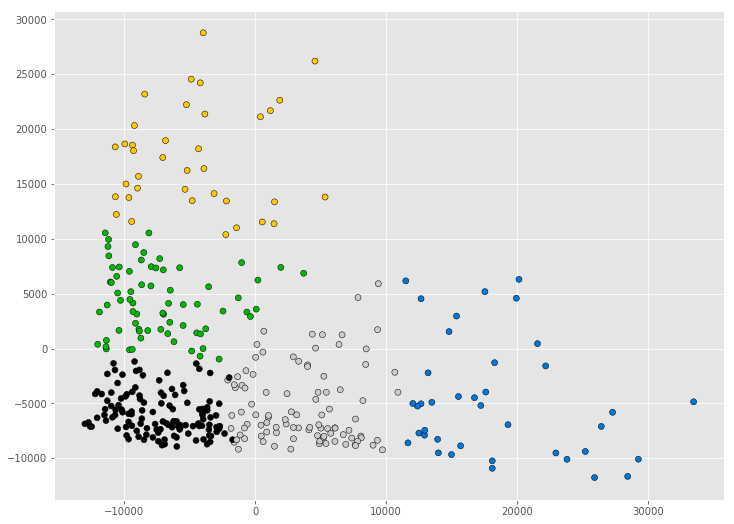

In [219]:
fig = plt.figure(1, figsize=(12, 9))
plt.clf()

plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(df)
pca_df = pca.transform(filt_df)

# Get clusters and labels from original 
labels, cluster_centers = getKMeansClusters(filt_df, print_clusters=False)

plt.scatter(pca_df[:,0], pca_df[:,1], c=labels, cmap=plt.cm.spectral,
           edgecolor='k')
plt.show()

In [221]:
# Convert Cluster_centers to a dictionary then to a JSON file
cluster_centers
attributes = list(df.columns.values)

cluster_means = {}
cluster_means[0] = {}
cluster_means[1] = {}
cluster_means[2] = {}
cluster_means[3] = {}
cluster_means[4] = {}
cluster_means

for i in range(5):
    for j, item in enumerate(attributes):
        cluster_means[i][item] = cluster_centers[i][j]

import json
with open('cluster_means.json', 'w') as fp:
    json.dump(cluster_means, fp)

<h2>Interesting Case Study (Model not pursued)</h2>

<p>Clustering with total money spent classifies clusters based on type of spending and amount of spending. In other others, it classfies the rich and the poor separately, even if their meals consists of the same items but at different brand quality. 

If we wanted to only classify the type of spending and not the amount of spending, we need to "normalize" the input data by dividing by the consumer's total spending. Which in turn allows us to cluster them based on the percentage of their spendings.<p>

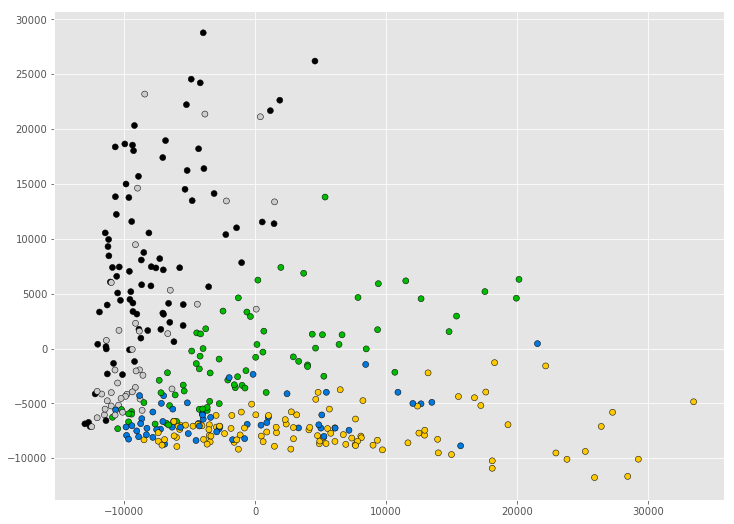

In [218]:
# Getting a percentage instead of actual spendings
df_normalized = filt_df.divide(filt_df.sum(axis=1), axis=0)

fig = plt.figure(1, figsize=(12, 9))
plt.clf()

plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(df)
pca_df = pca.transform(filt_df)

# Get clusters and labels from original 
n_labels, n_cluster_centers = getKMeansClusters(df_normalized, print_clusters=False)

plt.scatter(pca_df[:,0], pca_df[:,1], c=n_labels, cmap=plt.cm.spectral,
           edgecolor='k')
plt.show()

<p> The results of these clusters are shown to be more along the lines of a line, which makes sense, as the slope classifies the consumer, not the amount that they spend </p>

In [239]:
# Algorithm for classifying clusters
def findClosetCluster(vals):
    # vals is an dictionary that is similar to:
    # {'Fresh': 5418.5275590551209, 
    # 'Milk': 2336.0393700787477,
    # 'Grocery': 2704.0551181102255,
    # 'Frozen': 2616.4330708661414, 
    # 'Detergents_Paper': 661.55905511811261, 
    # 'Delicassen': 890.58267716535352}
    
    #lowest error initialized to some high value
    lowest_error = 10000000000
    
    # index initialized to 0, will be processed as function loops through more clusters
    lowest_error_cluster_index = 0
    
    #looping through 5 clusters
    for cluster in range(5):
        
        #error initialized to 0 to start off
        error = 0
        
        # Looping through each cluster items to calculate error
        for key, value in cluster_means[cluster].items():
            # Update Error based on L1 distance
            error = error + abs(cluster_means[cluster][key] - vals[key])
            
        #update error if error is lower than current error
        if error < lowest_error:
            lowest_error = error
            lowest_error_cluster_index = cluster
            
    #return the cluster with the lowest error, AKA classification of error
    return cluster_means[lowest_error_cluster_index]

In [240]:
findClosetCluster(cluster_means[0])

{'Delicassen': 890.58267716535352,
 'Detergents_Paper': 661.55905511811261,
 'Fresh': 5418.5275590551209,
 'Frozen': 2616.4330708661414,
 'Grocery': 2704.0551181102255,
 'Milk': 2336.0393700787477}